# Testing ePSF centroid analysis with photoutils

Following the tutorial at https://photutils.readthedocs.io/en/stable/epsf.html

## Building ePSF

Following the above reference, build ePSF from a simulated HST/WFC3 image in the F160W band.

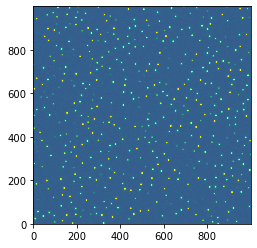

In [1]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.datasets import load_simulated_hst_star_image
from photutils.datasets import make_noise_image

hdu = load_simulated_hst_star_image()
data = hdu.data
data +=  make_noise_image(data.shape, distribution='gaussian', mean=10.,
                          stddev=5., seed=123)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

Using find_peaks() function, we will identify the bright stars with the detection threshold value to 500.0.

In [2]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   849      2  1076.7026
   182      4  1709.5671
   324      4  3006.0086
   100      9  1142.9915
   824      9  1302.8604
   934     12  891.53049
   135     15  1491.0008
   780     17  965.01121
   893     18  593.88605
   440     23  1235.3081
   ...    ...        ...
   437    985  1980.3149
   508    985  2626.4065
   984    987  738.99136
   950    988  2696.2486
   168    991  1693.8835
   635    991  3607.8909
   751    992  801.23834
   114    994  1595.2804
   299    994  648.18539
   207    998  2810.6503
   691    999  2611.0464
Length = 431 rows


Using extract_stars() function, we will extract 25 x 25 images around the selected stars. To this end, we exclude stars that are too close to the edge of the image. We create a mask for this.

In [3]:
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))
print(peaks_tbl[mask])

x_peak y_peak peak_value
------ ------ ----------
   135     15  1491.0008
   780     17  965.01121
   893     18  593.88605
   440     23  1235.3081
   847     29  2272.1741
   219     32  662.39008
   364     32  2187.7279
    47     36  3347.6478
   817     36  506.73238
   593     37  1286.4794
   ...    ...        ...
   354    953  771.18067
    65    959  1226.3602
   327    960   1525.786
   868    960  1694.8065
   156    962  1413.2975
   240    966  1996.3935
   721    966   926.6576
    92    969  1318.0544
   571    971  2317.2108
   437    985  1980.3149
   508    985  2626.4065
Length = 404 rows


We create the table of good stars positions.

In [4]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask] 
stars_tbl['y'] = y[mask] 

Befor cutout the image, we need to subtract the background. We use sigma-clipped median value as the background level, following the reference. We keep the original data as "image".

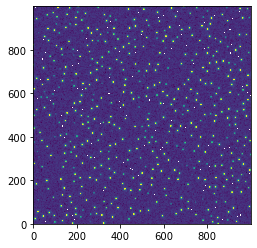

In [6]:
from astropy.stats import sigma_clipped_stats
from photutils.background import MMMBackground
import copy
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

Because the extract_stars() function requires the input data as an NDData oject. We create an NDData data array.

In [7]:
from astropy.nddata import NDData
nddata = NDData(data=data)  
print(nddata.data.shape)

(1000, 1000)


Now, we extract the 25x25 cutouts of the selected stars.

In [8]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25) 

Let's look at the first 25 of them.

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


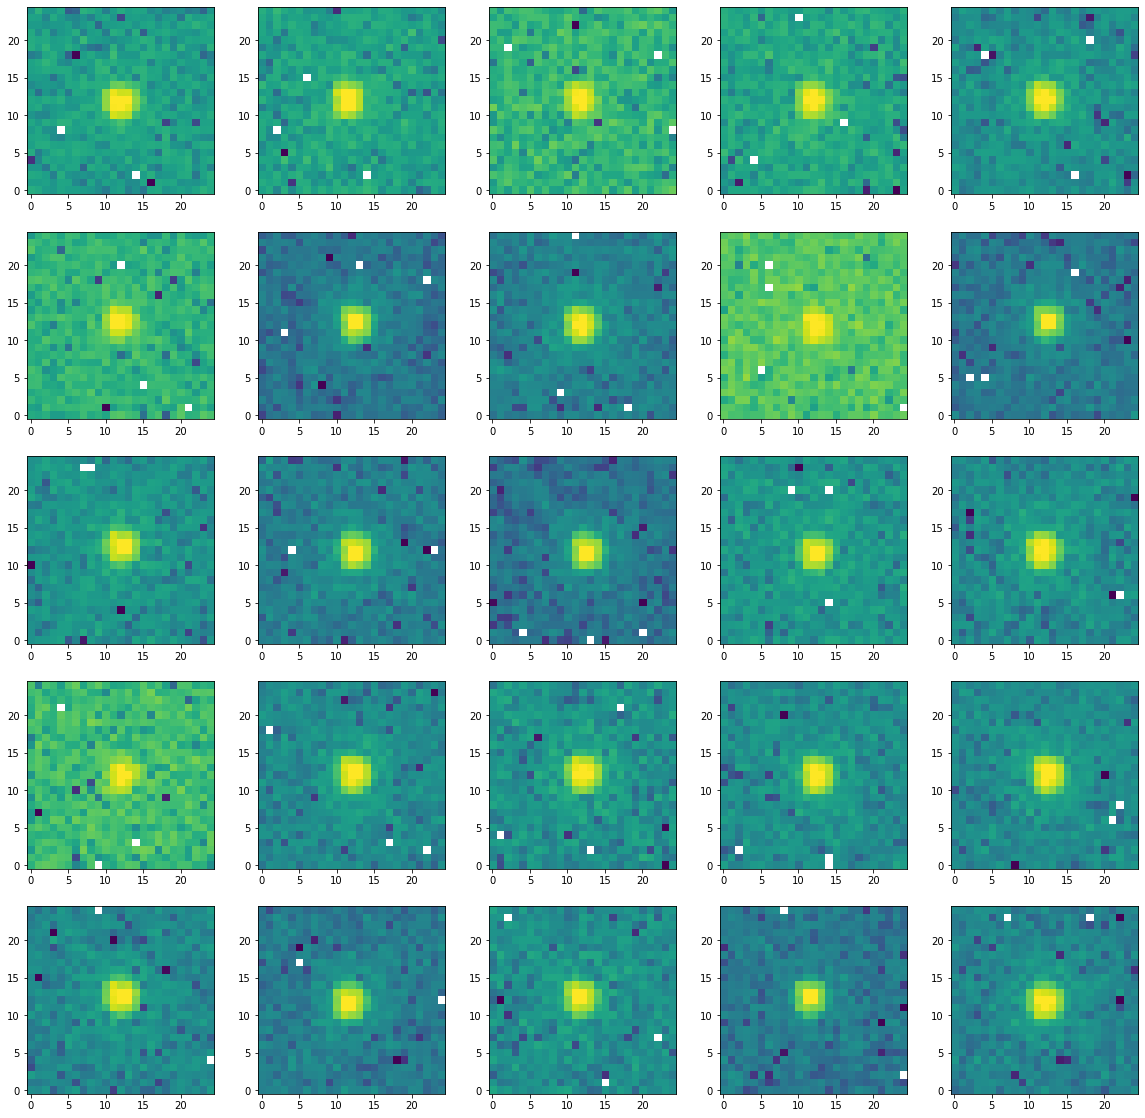

In [9]:
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

We construct ePSF with EPSFBuilder class with an oversampling factor of 4.0 and maximum number of iteration of 3.0 (10 is recommended in the tutorial). 

We firsr initialise an EPSFBuilder instance with our parameter values, and then run with the cutout data of stars. 

In [10]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars) 

Let's see the constructed ePSF.

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


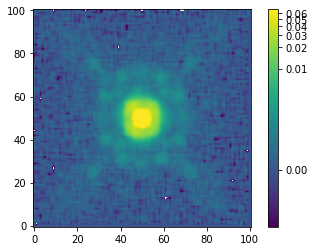

In [11]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

Let's look at the fitted stars results. 

In [12]:
print(fitted_stars.n_good_stars)

404


Let's do PSF photometry using the ePSF, following https://photutils.readthedocs.io/en/stable/psf.html and https://github.com/astropy/photutils-datasets/blob/main/notebooks/psf/ArtificialCrowdedFieldPSFPhotometry.ipynb . First, we initilise an IterativelySubtractedPSFPhotometry. We use a filter of LevMarLSQFitter, a source detection of IRAFStarFinder, grouping with DBSCANGroup and use the background of MMMBackground (though it is inconsistent with the above background used for ePSF) and ePSF for the PSF model.

In [41]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DBSCANGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()

std = bkgrms(image)

sigma_psf = 2.0

iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

grouper = DBSCANGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = epsf

fitter = LevMarLSQFitter()

We run PSF photometry with ePSF.

In [42]:
from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=grouper,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11))
result_tab = photometry(image)
residual_image = photometry.get_residual_image()

Let's plot original and residual images.

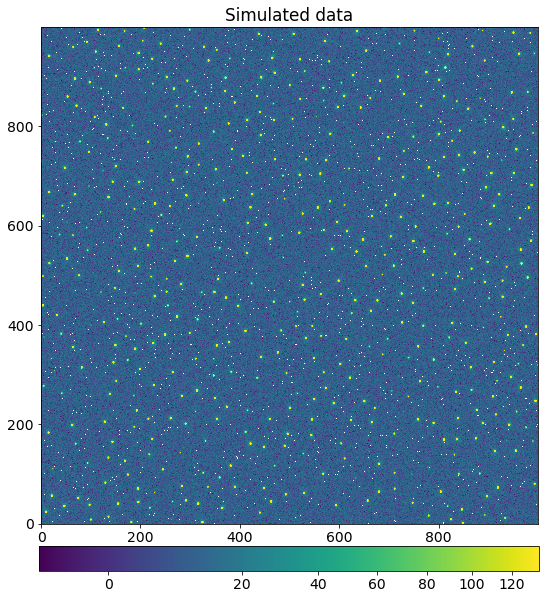

In [43]:
from matplotlib import rcParams
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'
rcParams['font.size'] = 14

norm = simple_norm(image, 'sqrt', percent=99.)
plt.imshow(image, norm=norm)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

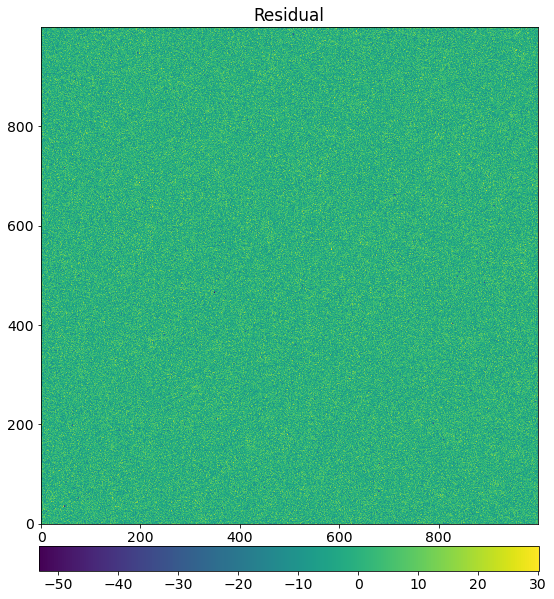

In [44]:
# norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(residual_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [45]:
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64
848.5912139803474,848.6331888503272,2.1692353960948734,2.1353217548328787,4207.25743153602,4329.851716148937,1,1,17.062985390519565,0.0032380372571605893,0.003198235967852954,1
181.8145652906441,181.88694165174192,3.7531185493338826,3.7941676931163384,5948.002425859674,5989.89687976933,2,2,15.424931868266109,0.0020931889843998027,0.002127617523125261,1
323.84923843190955,323.9141507744412,3.700074488470213,3.75180314522986,10641.867288563824,10761.604439479528,3,3,17.980888636737422,0.00146865498458389,0.0014048572472995535,1
99.86909980952039,99.92670766867806,8.949293058966024,8.986817359272935,3373.019618006479,3469.9534039837627,4,4,15.163633600001553,0.0038517916461155905,0.004104294061632303,1
824.1714377155344,824.1268111761137,9.347801390674299,9.312775674637612,4676.496642570799,4759.582979283602,5,5,16.93570377292488,0.002725376759539313,0.002736463434763667,1
262.06948679505115,262.09116199475557,9.854177396378313,9.714816851085637,274.470040123707,237.28965944413895,6,6,15.937009552245325,0.05706452626166592,0.05793742445368988,1
521.7336451254615,521.2259502801179,9.73119265260672,9.488091546266325,6.4342862631252125,50.139992330914424,7,7,14.173742025119482,0.20842344432357443,0.22289045027133975,1
933.5523465648039,933.583969225783,11.84144407218512,11.85861250256327,3905.8634992040866,3956.5726764285932,8,8,15.887982959103994,0.0033508814359339365,0.003821449683583507,1
134.9434410773527,134.97794076982936,14.679078769101139,14.707593898624442,5234.708586674488,5381.078894709564,9,9,14.521866672102629,0.0026210922805146356,0.0023378595003465587,1


Let's plot uncertainty vs. flux.

(0.001, 30.0)

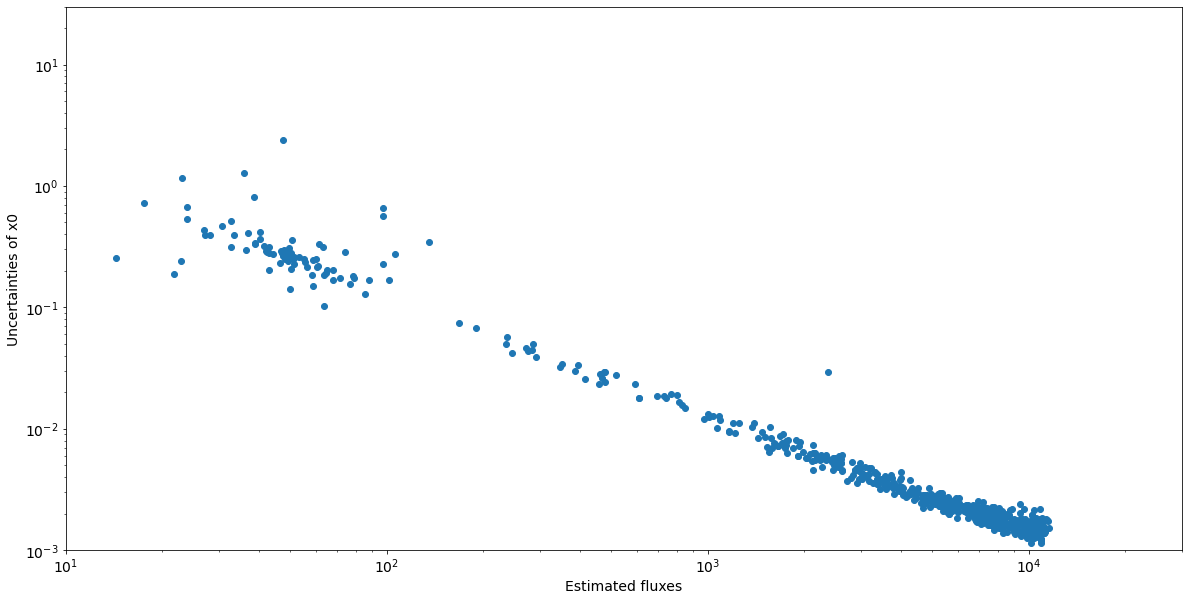

In [52]:
import numpy as np
plt.scatter(result_tab['flux_fit'], result_tab['x_0_unc'])
plt.xlabel('Estimated fluxes')
plt.ylabel('Uncertainties of x0')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10.0, 30000])
plt.ylim([1.0e-3, 30.0])

Next we run PSF photometry with Gaussian PSF.

In [47]:
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

photometry_gpsf = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=grouper,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11))
result_gpsf_tab = photometry_gpsf(image)
residual_gpsf_image = photometry_gpsf.get_residual_image()

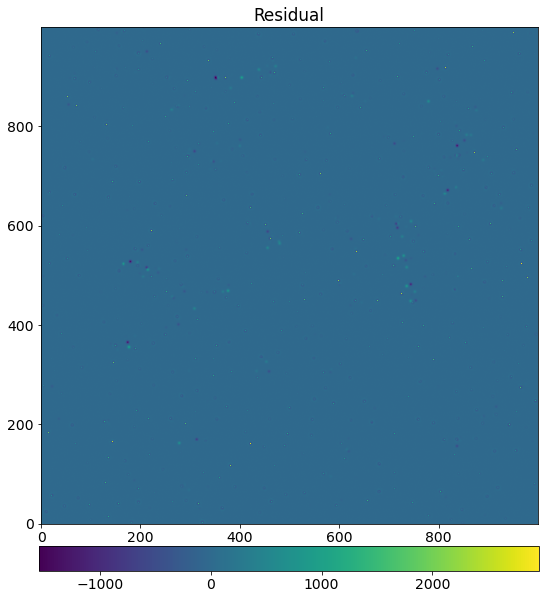

In [48]:
# norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(residual_gpsf_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

(0.001, 30.0)

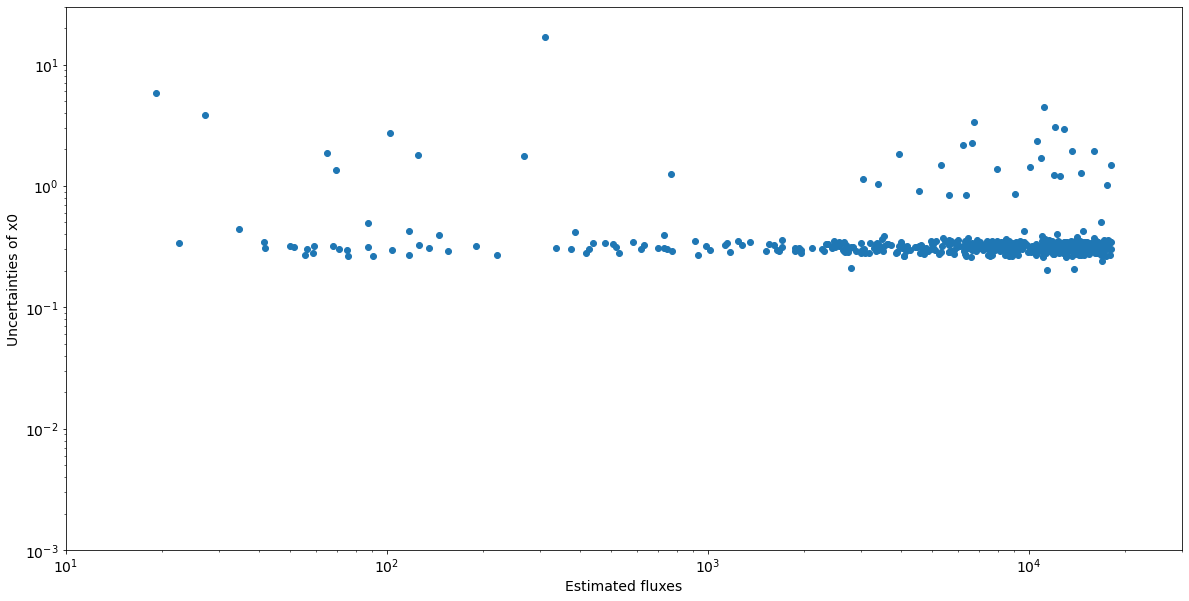

In [51]:
plt.scatter(result_gpsf_tab['flux_fit'], result_gpsf_tab['x_0_unc'])
plt.xlabel('Estimated fluxes')
plt.ylabel('Uncertainties of x0')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10.0, 30000])
plt.ylim([1.0e-3, 30.0])